# Exercise three: emotion text recognition

## Import libraries and read data

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from transformers import pipeline
from collections import Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

First, we import all the necessary libraries and packages.

In [32]:
df = pd.read_csv("data/test.csv")

labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
df['label_name'] = df['label'].map(labels_dict)
df.head()

,text,label,label_name
0,im feeling rather rotten so im not very ambiti...,0,sadness
1,im updating my blog because i feel shitty,0,sadness
2,i never make her separate from me because i do...,0,sadness
3,i left with my bouquet of red and yellow tulip...,1,joy
4,i was feeling a little vain when i did this one,0,sadness


Next, we open the file in dataframe using panda. We then define the dictionary of the labels and their corresponding emotion. We print the head of the dataframe to check if it reads correctly.

In [4]:
label_name = list(labels_dict.values())
print(label_name)

label_group = df['label']
count_original_labels = Counter(label_group).values()
print(count_original_labels)

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
dict_values([581, 695, 224, 275, 159, 66])


Next, we map identifiers to the labels, and converts all the dictionary's values into a list. This list, stored in label_name, is then printed. Then we select the 'label' column from a DataFrame df. We use the counter to count the frequency of each unique value (label) in the column. Afterwards, we print the values from the resulting Counter object, which would be the counts of each label.

In [5]:
text = df["text"]
label = df["label"]

Then we assign the two columns of our data from a pandas DataFrame df to variables.

In [6]:
row_delimiter = '\n'
text_string = row_delimiter.join(df['text'].astype(str))

We make the text column a string, dividing each sentence with the delimiter \n so that we can later use it in the model.

## Building similarity model

In [7]:
nlp_trf = spacy.load('en_core_web_lg')

We import the English NLP module of Spacy in the large (lg) version, since we have a pretty big dataset

In [10]:
label_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

textual_labels = [label_mapping[l] for l in label]

We make a new variable "textual_labels" so that we can later use it, and try to make more efficient similarities.

In [37]:
def emo_oracle(magic_word, data_point):
    text_string, textual_labels = data_point
    similarities = []
    summary = nlp_trf(text_string)
    tokens = [token.text for token in summary]

    for label in textual_labels:
        try: 
            idx = tokens.index(label)
            similarity = magic_word[0:5].similarity(summary[idx])
            similarities.append((label, similarity))
        except ValueError: 
            similarities.append((label, -1))
    
    max_similarity_label = max(similarities, key=lambda x: x[1])[0]
    return max_similarity_label

magic_word = nlp_trf('sadness joy love anger fear surprise')

predictions = []
with open("predictions_model.txt", "w") as file:
    # Iterate over each text and label in your dataset
    for text, label in zip(df['text'], df['label']):
        # Get the prediction using the emo_oracle function
        prediction = emo_oracle(magic_word, (text, textual_labels))
        predictions.append(prediction)
        # Write the text, label, and prediction to the file
        file.write(f"Text: {text}\n")
        file.write(f"True Label: {label}\n")
        file.write(f"Prediction: {prediction}\n")
        file.write("\n")

We define the model "emo_oracle" which tries to assign an emotion label to each sentence based on the similarity between the sentence and the name of the label. The prediction of the label is given by the maximum similarity, which here appears to be almost always with the "sadness" label. The output are saved in the file "predictions_model.txt". 

In [21]:
correct_predictions = 0
total_predictions = len(predictions)

for prediction, true_label in zip(predictions, textual_labels):
    if prediction == true_label:
        correct_predictions += 1

accuracy = correct_predictions / total_predictions
baseline_accuracy = max(count_original_labels) / len(label_group)  

print ('Model accuracy:', accuracy)
print('Baseline accuracy:', baseline_accuracy)

Model accuracy: 0.2895
Baseline accuracy: 0.3475


Here we calculate the accuracy of the model summing the number of correct predictions over their total (2000). We also calculate the baseline accuracy which is given by the most frequent label in the original dataset and the total of the labels.

In [22]:
counts = {i:predictions.count(i) for i in predictions}
print(counts)
count_model_labels = counts.values()

{'sadness': 1932, 'anger': 7, 'love': 48, 'fear': 6, 'joy': 5, 'surprise': 2}


We count the frequency of each label, showing the big preference for the sadness label, which is the biggest limitation with this model.
We will later use these frequency to build the graphs.

## Sentiment Analysis with VADER

In [23]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/emma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

We then tried the sentiment analysis to make emotion prediction for the same data. First of all, we import the VADER lexicon from nltk.

In [24]:
sid = SentimentIntensityAnalyzer()

Next, we initialize an instance of the SentimentIntensityAnalyzer class from the VADER sentiment analysis tool. With VADER, we will be able to obtain the sentiment score.

In [26]:
def predict_emotion_label(sentiment_score):
    if sentiment_score >= 0.5:
        return 1  # joy
    elif sentiment_score >= 0.2:
        return 2  # love
    elif sentiment_score >= -0.2:
        return 3  # anger
    elif sentiment_score >= -0.5:
        return 4  # fear
    elif sentiment_score >= -0.7:
        return 5  # surprise
    else:
        return 0  # sadness

predictions_vader = []
with open("predictions_VADER.txt", 'w') as file:
    for index, row in df.iterrows():
        text_data = row['text']
        label = row['label']

        sentiment_score = sid.polarity_scores(text_data)['compound']

        predicted_emotion_label = predict_emotion_label(sentiment_score)

        predictions_vader.append(predicted_emotion_label)
        file.write(f"Text: {text_data}\n")
        file.write(f"True Label: {label}\n")
        file.write(f"Predicted emotion label: {predicted_emotion_label}, {label_name[predicted_emotion_label]}\n")

Then, we define the predict_emotion_label function to predict emotion labels. This step takes a sentiment score as input and predicts the emotion label based on the score, which is obtained using VADER. Depending on the range of sentiment scores, the function maps them to one of the six emotional categories using predefined thresholds.

Next, we iterate through each row of the DataFrame df. For each row, it extracts the text data and the corresponding label; analyzes the sentiment of the text using VADER and obtains the compound sentiment score; and predicts the emotion label based on the sentiment score using the predict_emotion_label function.

We save our outputs in the file "predictions_VADER.txt".

In [27]:
correct_predictions_vader = 0

# Iterate over each prediction and true label
for predicted_emotion_label, true_label in zip(predictions_vader, df["label"]):
    # Check if the prediction matches the true label
    if predicted_emotion_label == true_label:
        # Increment the count of correct predictions
        correct_predictions_vader += 1

# Calculate the accuracy
accuracy = correct_predictions_vader / total_predictions

baseline_accuracy = max(count_original_labels) / len(label_group) 

print("VADER accuracy:", accuracy)
print("baseline_accuracy:", baseline_accuracy)

VADER accuracy: 0.3395
baseline_accuracy: 0.3475


After getting the result, we get to examine the model's quality by checking its accuracy compared with the baseline accuracy.

We set correct_predictions_vader to 0 to  keep track of the number of times the predicted emotion label matches the true label.

Then we ask to  iterate over each prediction made by VADER alongside the true label from our dataset.  Inside the loop, it checks if the predicted label matches the true label. If so, it increments correct_predictions_vader by 1.

After the loop, we calculate the accuracy by dividing the number of correct predictions by the total number of predictions.We then calculate the baseline accuracy as the maximum count of any label in your dataset divided by the total number of labels.

Finally, we print them out.

In [28]:
label_counts_vader = {}

# Iterate over each predicted emotion label in the list
for predict_emotion_label in predictions_vader:
    # Check if the label is already in the dictionary, if not, initialize its count to 0
    if predict_emotion_label not in label_counts_vader:
        label_counts_vader[predict_emotion_label] = 0
    # Increment the count of the current label
    label_counts_vader[predict_emotion_label] += 1

# Print the counts of each predicted emotion label
for label, count in label_counts_vader.items():
    print(f"{label}: {count}")

5: 193
3: 317
2: 309
4: 370
1: 644
0: 167


Furthermore, we count and display the frequency of each predicted emotion label in the list of predictions.

In [33]:
sorted_vader_count= dict(sorted(label_counts_vader.items()))
count_vader_label = sorted_vader_count.values()
print(count_vader_label)

dict_values([167, 644, 309, 317, 370, 193])


We sort the dictionary label_counts_vader by its keys and then we extract and print the sorted dictionary and the counts of each label.

## Sentiment Analysis with FEEL-IT

In [59]:
df_it = pd.read_excel("data/italian_text.xlsx")
df_it.head()
testo = df_it["testo"]

Here is our emotion prediction using FEEL-IT with our Italian translation. First, we read the file and print the head to make a quick check of the data.

In [62]:
classifier = pipeline("text-classification", model='MilaNLProc/feel-it-italian-emotion', top_k=2)

def get_emotion(sentence):
    try:
        prediction = classifier(sentence)
        return prediction[0][0]['label'], prediction[0][0]['score']
    except Exception as e:
        print(f"Error processing sentence: {sentence}. Error: {e}")
        return None, None

df_it[['emotion', 'score']] = df_it['testo'].apply(lambda x: pd.Series(get_emotion(x)))

with open("predictions_FEEL-IT.txt", "w") as file:
    for index, row in df_it.iterrows():
        file.write(f"Sentence: {row['testo']}\n")
        file.write(f"Predicted Emotion: {row['emotion']}\n\n")

We first create a pipeline for text classification, in which we initialize a text classification pipeline using the specified pre-trained model. The pipeline is stored in the variable classifier.

Then, we define a function named get_emotion that takes a single argument sentence, and obtains emotion predictions.

Third, we apply the classifier to the dataframe. We apply the get_emotion function to each sentence in the DataFrame column 'testo'. The resulting emotion labels and scores are unpacked into separate columns named 'emotion' and 'score', respectively.

Finally, we ask the loop to iterate over each row (sentence) in the DataFrame, and print out the original sentence along with its predicted emotion.

In [65]:
emotion_counts = Counter(df['emotion'])
for emotion, count in emotion_counts.items():
    print(f"Emotion: {emotion}, Frequency: {count}")

Emotion: anger, Frequency: 274
Emotion: joy, Frequency: 605
Emotion: sadness, Frequency: 950
Emotion: fear, Frequency: 171


Next, we calculate the counts for each predicted emotion. We used the counter to count the occurrences of each unique emotion label in the 'emotion' column of the DataFrame.

In [66]:
feel_it_dict = {}
for emotion, count in emotion_counts.items():
    feel_it_dict[emotion] = count

Then we iterate over a dictionary named emotion_counts, storing its contents into a new dictionary called feel_it_dict.

In [67]:
labels_feel_it = feel_it_dict.keys()
counts_feel_it = feel_it_dict.values()
print(labels_feel_it, counts_feel_it)

dict_keys(['anger', 'joy', 'sadness', 'fear']) dict_values([274, 605, 950, 171])


We extract the keys and values from the feel_it_dict dictionary and print them.

## Building Graphs

In this section we plot bar plots for the original dataset as well as the generated outputs by the similarity model, the VADER model and the FEEL-IT one. 
We will put the names of the labels on the x axis and their frequency on the y axis, in this way we will be able to compare them, it will me a visual measure of their accuracy. 
The only graph that will be slightly different from the others in terms of variables will be the "FEEL-It" one, because it will have just 4 labels names, instead of six, since the model provides less labels than our original dataset. 

### Plot bar frequency of original labels

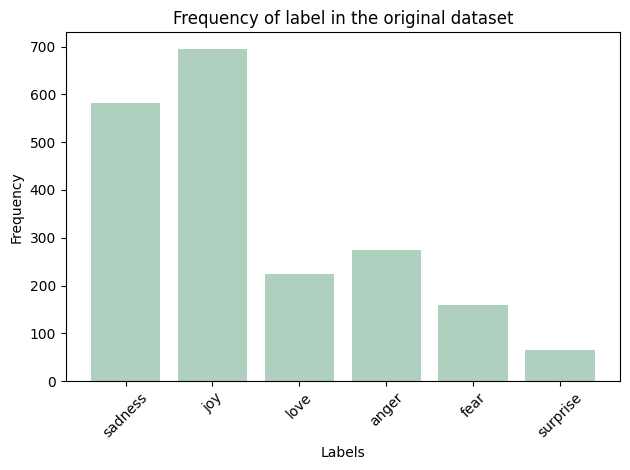

In [46]:
plt.bar(label_name, count_original_labels, color = "#AFD0BF")

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of label in the original dataset')

plt.xticks(rotation=45)

plt.tight_layout() 

### Plot bar similarity model

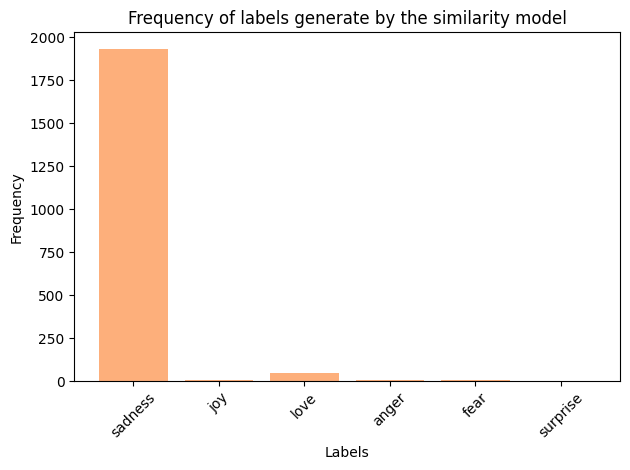

In [47]:
plt.bar(label_name, count_model_labels, color = "#FDAF7B")

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of labels generate by the similarity model')

plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()

### Plot bar sentiment analysis with VADER

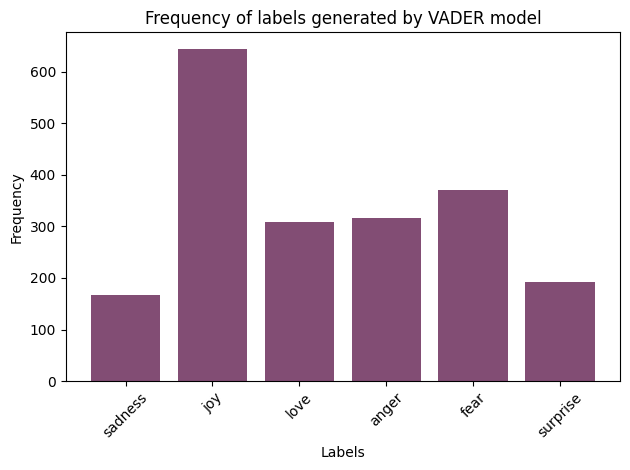

In [48]:
plt.bar(label_name, count_vader_label, color = "#824D74")

plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of labels generated by VADER model')

plt.xticks(rotation=45)

plt.tight_layout() 
plt.show()

### Plot bar sentiment analysis with FEEL-IT

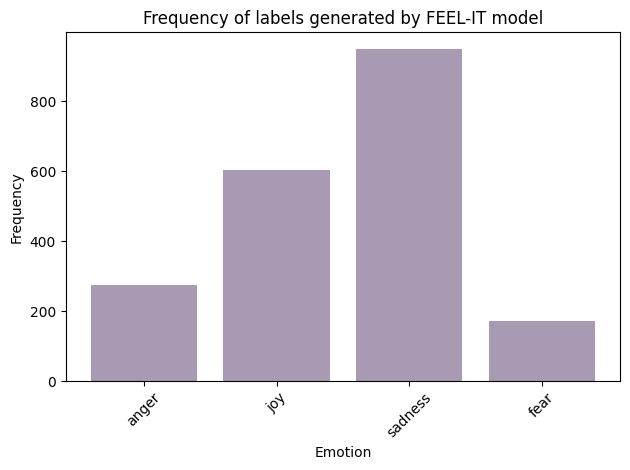

In [68]:
plt.bar(labels_feel_it, counts_feel_it, color="#A79AB2")

plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Frequency of labels generated by FEEL-IT model')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()